In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from obspy.signal.filter import envelope
from obspy.geodetics import gps2dist_azimuth
from obspy import read
from obspy.signal import util
from obspy.signal import cross_correlation
import numpy as np
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from obspy import Trace, read
from obspy.signal.util import smooth
from obspy.signal.tf_misfit import cwt
from datetime import timedelta, datetime
import ScientificColourMaps6 as SCM6
import matplotlib.dates as mdates
from scipy.fft import fftfreq 
from scipy.signal import butter, filtfilt
from obspy.signal.util import smooth
import matplotlib.patches as patches
import matplotlib.patheffects as pe

In [12]:
# Get BFO seismic data

c = Client("IRIS")

t1 = UTCDateTime(2023, 9, 16, 11, 30)
t2 = UTCDateTime(2023, 9, 17, 4, 0)

st = c.get_waveforms("II", "BFO", "10", "LH*", t1, t2, attach_response=True)
inv = c.get_stations(network="II", station="BFO", location="10", level="response")

st2 = st.copy()
st2.remove_response(inv, output="DISP")
st2.detrend()
st2.filter("lowpass", freq=13e-3)
st2.filter("lowpass", freq=13e-3)
st2.filter("highpass", freq=10e-3)
st2.taper(max_percentage=0.02)

dist, az, baz = gps2dist_azimuth(72.794, -27.013, inv[0][0].latitude, inv[0][0].longitude)
st2.rotate("NE->RT", inventory=inv, back_azimuth=baz)

3 Trace(s) in Stream:
II.BFO.10.LHT | 2023-09-16T11:30:00.069538Z - 2023-09-17T03:59:59.069538Z | 1.0 Hz, 59400 samples
II.BFO.10.LHR | 2023-09-16T11:30:00.069538Z - 2023-09-17T03:59:59.069538Z | 1.0 Hz, 59400 samples
II.BFO.10.LHZ | 2023-09-16T11:30:00.069538Z - 2023-09-17T03:59:59.069538Z | 1.0 Hz, 59400 samples

In [13]:
# Read in synthetic data using horizontal force modeling

st_synth = read("/Users/sph1r17/Downloads/BFO_synth.msd", format="MSEED")
st_synth.detrend()
st_synth.filter("lowpass", freq=12e-3)
st_synth.filter("lowpass", freq=12e-3)
st_synth.filter("highpass", freq=10e-3)
st_synth.taper(max_percentage=0.02)

3 Trace(s) in Stream:
SY.BFO.SE.LXZ | 2023-09-16T11:35:50.000000Z - 2023-09-17T05:17:18.000000Z | 1.0 Hz, 63689 samples
SY.BFO.SE.LXR | 2023-09-16T11:35:50.000000Z - 2023-09-17T05:17:18.000000Z | 1.0 Hz, 63689 samples
SY.BFO.SE.LXT | 2023-09-16T11:35:50.000000Z - 2023-09-17T05:17:18.000000Z | 1.0 Hz, 63689 samples

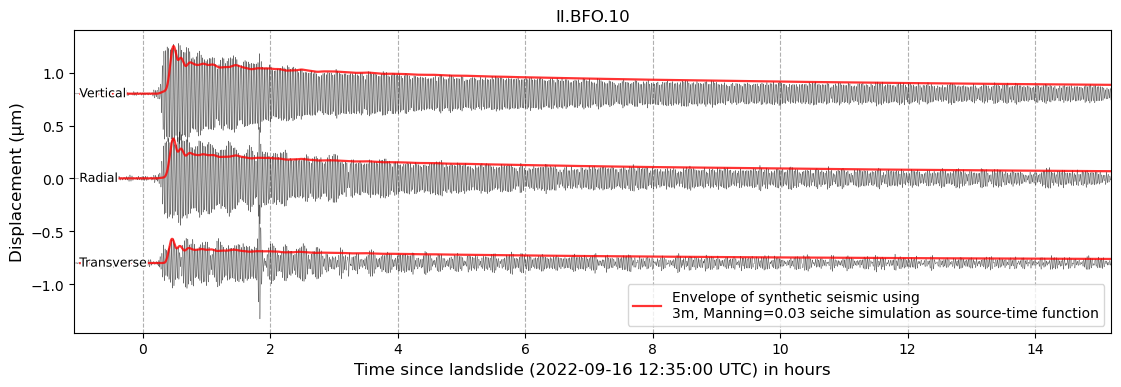

In [14]:
# Now plot
fig = plt.figure(figsize=(34/2.54, 10/2.54)) #14/2.54))
ax = plt.subplot()

ot = UTCDateTime(2023, 9, 16, 12, 35)

shift = [0.8, 0, -0.8]
colors = ["blue", "orange", "green"]
for n, tr in enumerate(reversed(st2)): 
    ax.plot(tr.times(reftime=ot)/3600, (tr.data*1e6)+shift[n], alpha=0.7, lw=0.3, c="k")

    tr_synth = st_synth.select(component=tr.stats.channel[-1])[0]
    if n == 0:
        label = "Envelope of synthetic seismic using\n3m, Manning=0.03 seiche simulation as source-time function"
    else:
        label = ""
    ax.plot(tr_synth.times(reftime=ot)/3600, 1*envelope(-1*tr_synth.data*1e6)+shift[n], alpha=0.8, lw=1.6, c="red", label=label)
    if tr.stats.channel[2] == "Z":
        name = "Vertical"
    elif tr.stats.channel[2] == "R":
        name = "Radial"
    elif tr.stats.channel[2] == "T":
        name = "Transverse"
        
    ax.text(-1, shift[n], name, va="center", path_effects=[pe.withStroke(linewidth=2.5, foreground="white")], fontsize=9)
        
ax.set_ylabel("Seiche amplitude (m)")
ax.set_xlabel("Time (hours)")
ax.set_title("$dx$ = 15 m")

ax.set_xlabel("Time since landslide (2022-09-16 12:35:00 UTC) in hours", fontsize=12)
ax.set_ylabel("Displacement (μm)", fontsize=12)

ax.grid(ls="--", axis="x")#
ax.margins(x=0)
ax.set_title("II.BFO.10")
ax.set_xlim(ax.get_xlim()[0], 15.2)
lines, labels = ax.get_legend_handles_labels()
ax.legend(loc=4)

plt.savefig("Figure5C.png", dpi=300, bbox_inches="tight", transparent=True)